## K-fold cross validation - Regression Model

In [1]:
%load_ext lab_black

In [2]:
import logging
import os
import os.path
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split

from ludwig.api import kfold_cross_validate, LudwigModel

2021-08-30 12:30:46.742982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 12:30:46.743070: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Contstants

In [3]:
DATA_SET_URL = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)
DATA_SET = "auto_mpg.data"
RESULTS_DIR = "results"

### Clean out previous results

In [4]:
if os.path.isfile(DATA_SET):
    os.remove(DATA_SET)

shutil.rmtree(RESULTS_DIR, ignore_errors=True)

### Retrieve data from UCI Machine Learning Repository
#### Download required data

In [5]:
r = requests.get(DATA_SET_URL)
if r.status_code == 200:
    with open(DATA_SET, "w") as f:
        f.write(r.content.decode("utf-8"))

#### Create Pandas DataFrame from downloaded data

In [6]:
raw_df = pd.read_csv(
    DATA_SET, header=None, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)


raw_df.columns = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "ModelYear",
    "Origin",
]
raw_df.shape

(398, 8)

In [7]:
raw_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


#### Create train/test split

In [8]:
train_df, test_df = train_test_split(raw_df, train_size=0.8, random_state=17)
print(train_df.shape)
print(test_df.shape)

(318, 8)
(80, 8)


### Setup Ludwig config


In [9]:
num_features = [
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "ModelYear",
]
cat_features = ["Origin"]

#### Create Ludwig input_features

In [10]:
input_features = []
# setup input features for numerical variables
for p in num_features:
    a_feature = {
        "name": p,
        "type": "numerical",
        "preprocessing": {
            "missing_value_strategy": "fill_with_mean",
            "normalization": "zscore",
        },
    }
    input_features.append(a_feature)

# setkup input features for categorical variables
for p in cat_features:
    a_feature = {"name": p, "type": "category"}

#### Create Ludwig output features

In [11]:
output_features = [
    {"name": "MPG", "type": "numerical", "num_fc_layers": 2, "fc_size": 64}
]

In [12]:
config = {
    "input_features": input_features,
    "output_features": output_features,
    "training": {"epochs": 100, "batch_size": 32},
}
config

{'input_features': [{'name': 'Cylinders',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Displacement',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Horsepower',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Weight',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'Acceleration',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'ModelYear',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}}],
 'output_features': [{'name': 'MPG',
   'type': 'numerical',
   'num_fc_layers': 2,
   'fc_size': 64}

### Perform K-fold Cross Validation analysis

In [13]:
%%time
with tempfile.TemporaryDirectory() as tmpdir:
    data_csv_fp = os.path.join(tmpdir,'train.csv')
    train_df.to_csv(data_csv_fp, index=False)

    (
        kfold_cv_stats, 
        kfold_split_indices 
    ) = kfold_cross_validate(
        num_folds=5,
        config=config,
        dataset=data_csv_fp,
        output_directory=tmpdir,
        logging_level=logging.ERROR
    )

starting 5-fold cross validation
training on fold 1


2021-08-30 12:31:09.298717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-30 12:31:09.298829: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-30 12:31:09.299008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a5e58c64dcf3): /proc/driver/nvidia/version does not exist
2021-08-30 12:31:11.237499: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-30 12:31:18.834282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR O

CPU times: user 3min 7s, sys: 16.5 s, total: 3min 23s
Wall time: 3min 54s


In [14]:
kfold_cv_stats["overall"]["MPG"]

{'loss_mean': 8.133892,
 'loss_std': 2.4823751,
 'error_mean': 0.040548533,
 'error_std': 0.59294134,
 'mean_squared_error_mean': 8.133892,
 'mean_squared_error_std': 2.4823751,
 'mean_absolute_error_mean': 2.0577884,
 'mean_absolute_error_std': 0.27885678,
 'r2_mean': 0.86646616,
 'r2_std': 0.035243824}

### Train model and assess model performance

In [15]:
model = LudwigModel(config=config, logging_level=logging.ERROR)

In [16]:
%%time
training_stats = model.train(
    training_set=train_df,
    output_directory=RESULTS_DIR,
)

CPU times: user 26.6 s, sys: 1.88 s, total: 28.5 s
Wall time: 49.4 s


In [17]:
test_stats, mpg_hat_df, _ = model.evaluate(
    dataset=test_df, collect_predictions=True, collect_overall_stats=True
)

In [18]:
test_stats

{'MPG': {'loss': 8.298665,
  'error': -0.47260332,
  'mean_squared_error': 8.298665,
  'mean_absolute_error': 2.228252,
  'r2': 0.8559038},
 'combined': {'loss': 8.298665}}

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


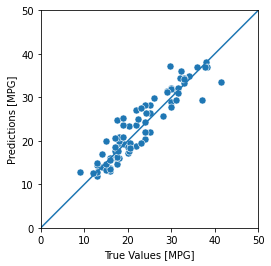

In [19]:
a = plt.axes(aspect="equal")
sns.scatterplot(test_df["MPG"].values, mpg_hat_df["MPG_predictions"].values, s=50)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Compare K-fold Cross Validation metrics against hold-out test metrics
#### Hold-out Test Metrics

In [20]:
test_stats["MPG"]

{'loss': 8.298665,
 'error': -0.47260332,
 'mean_squared_error': 8.298665,
 'mean_absolute_error': 2.228252,
 'r2': 0.8559038}

#### K-fold Cross Validation Metrics

In [21]:
kfold_cv_stats["overall"]["MPG"]

{'loss_mean': 8.133892,
 'loss_std': 2.4823751,
 'error_mean': 0.040548533,
 'error_std': 0.59294134,
 'mean_squared_error_mean': 8.133892,
 'mean_squared_error_std': 2.4823751,
 'mean_absolute_error_mean': 2.0577884,
 'mean_absolute_error_std': 0.27885678,
 'r2_mean': 0.86646616,
 'r2_std': 0.035243824}